In [33]:
# here is a mathematical expression that takes 3 inputs and produces one output
from math import sin, cos

def f(a, b, c):
  return -a**3 + sin(3*b) - 1.0/c + b**2.5 - a**0.5

print(f(2, 3, 4))

6.336362190988558


In [34]:
# write the function df that returns the analytical gradient of f
# i.e. use your skills from calculus to take the derivative, then implement the formula
# if you do not calculus then feel free to ask wolframalpha, e.g.:
# https://www.wolframalpha.com/input?i=d%2Fda%28sin%283*a%29%29%29

def gradf(a, b, c):
    
  return [
      -3*a**2 - 0.5*a**-0.5, 
      3*cos(3*b) + 2.5*b**1.5, 
      c**-2
  ] # todo, return [df/da, df/db, df/dc]

# expected answer is the list of 
ans = [-12.353553390593273, 10.25699027111255, 0.0625]
yours = gradf(2, 3, 4)
for dim in range(3):
  ok = 'OK' if abs(yours[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {yours[dim]}")

OK for dim 0: expected -12.353553390593273, yours returns -12.353553390593273
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027111255
OK for dim 2: expected 0.0625, yours returns 0.0625


In [35]:
# now estimate the gradient numerically without any calculus, using
# the approximation we used in the video.
# you should not call the function df from the last cell

# -----------
delta = 0.000001

f_original = f(2, 3, 4)

numerical_grad = [0, 0, 0] # TODO

f_delta_a = f(2 + delta, 3, 4)
f_delta_b = f(2, 3 + delta, 4)
f_delta_c = f(2, 3, 4 + delta)

numerical_grad[0] = (f_delta_a - f_original)/delta
numerical_grad[1] = (f_delta_b - f_original)/delta
numerical_grad[2] = (f_delta_c - f_original)/delta
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad[dim]}")

OK for dim 0: expected -12.353553390593273, yours returns -12.353559348809995
OK for dim 1: expected 10.25699027111255, yours returns 10.256991666679482
OK for dim 2: expected 0.0625, yours returns 0.062499984743169534


In [36]:
# there is an alternative formula that provides a much better numerical 
# approximation to the derivative of a function.
# learn about it here: https://en.wikipedia.org/wiki/Symmetric_derivative
# implement it. confirm that for the same step size h this version gives a
# better approximation.

# -----------
numerical_grad2 = [0, 0, 0] # TODO
# -----------

h = 0.000001

f_delta_a1 = f(2 + h, 3, 4)
f_delta_a2 = f(2 - h, 3, 4)

f_delta_b1 = f(2, 3 + h, 4)
f_delta_b2 = f(2, 3 - h, 4)

f_delta_c1 = f(2, 3, 4 + h)
f_delta_c2 = f(2, 3, 4 - h)

numerical_grad2[0] = (f_delta_a1 - f_delta_a2)/(2*h)
numerical_grad2[1] = (f_delta_b1 - f_delta_b2)/(2*h)
numerical_grad2[2] = (f_delta_c1 - f_delta_c2)/(2*h)



for dim in range(3):
  ok = 'OK' if abs(numerical_grad2[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad2[dim]}")

OK for dim 0: expected -12.353553390593273, yours returns -12.353553391353245
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027401572
OK for dim 2: expected 0.0625, yours returns 0.06250000028629188


In [144]:
# Value class starter code, with many functions taken out
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
      
    def __add__(self, other): # exactly as in the video
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1

    def __rtruediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return other * self**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "supported data types for power is int and float"

        out = Value(self.data**other, (self, ), "^")
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad

        out._backward = _backward

        return out


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
        
        out._backward = _backward

        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'e')

        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out

    def log(self):
        assert self.data > 0, "Logarithm is undefined for negative values"
        out = Value(math.log(self.data), (self, ), 'log')

        def _backward():
            self.grad += (1/self.data)*out.grad
        
        out._backward = _backward
        
        return out

    def __neg__(self):
        return self * -1

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                  build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [135]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.005653302662216329
OK for dim 3: expected -0.8864503806400986, yours returns -0.8864503806400986


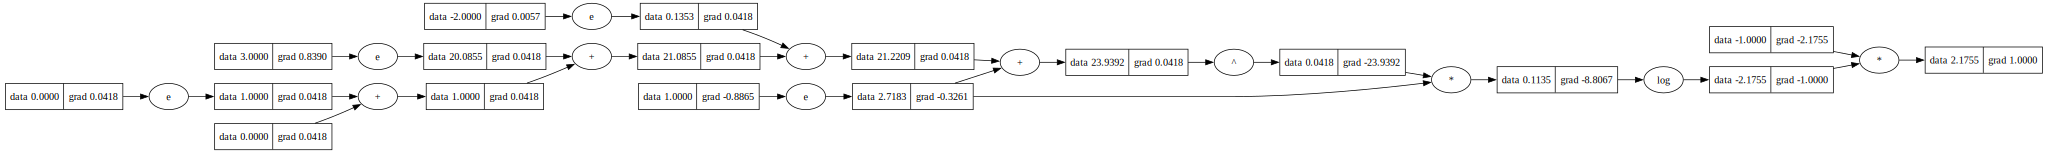

In [147]:
# without referencing our code/video __too__ much, make this cell work
# you'll have to implement (in some cases re-implemented) a number of functions
# of the Value object, similar to what we've seen in the video.
# instead of the squared error loss this implements the negative log likelihood
# loss, which is very often used in classification.

# this is the softmax function
# https://en.wikipedia.org/wiki/Softmax_function
def softmax(logits):
    counts = [logit.exp() for logit in logits]
    denominator = sum(counts)
    out = [c / denominator for c in counts]
    return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)

loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
  ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")

draw_dot(loss)

In [141]:
# verify the gradient using the torch library
# torch should give you the exact same gradient
import torch

logits = torch.tensor([0.0, 3.0, -2.0, 1.0], requires_grad=True)

probs = torch.softmax(logits, dim=0)

loss = -torch.log(probs[3])

loss.backward()

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]

for i, grad in enumerate(logits.grad.tolist()):
    diff = abs(grad - ans[i])
    status = "OK" if diff < 1e-5 else "WRONG"
    print(f"{status} for dim {i}: Expected {ans[i]}, PyTorch returned {grad}")


OK for dim 0: Expected 0.041772570515350445, PyTorch returned 0.041772566735744476
OK for dim 1: Expected 0.8390245074625319, PyTorch returned 0.8390244841575623
OK for dim 2: Expected 0.005653302662216329, PyTorch returned 0.005653302650898695
OK for dim 3: Expected -0.8864503806400986, PyTorch returned -0.8864504098892212
